# This demo shows an approach to change model actuators at runtime.

In mujoco all types of actuators are transformed to one unique model. That allows to change actuators to control `position`, `velocity` or `torque` specifically.

Description of the actuation model is available [here](https://mujoco.readthedocs.io/en/latest/computation/index.html#actuation-model).


In [1]:
import mujoco
import mediapy

## We will work and load kuka iiwa 14 for this demo

In [2]:
# scene is copied manually to change camera position
scene_xml = """
<mujoco model="iiwa14 scene">
  <include file="mujoco_menagerie/kuka_iiwa_14/iiwa14.xml"/>
  <compiler meshdir="mujoco_menagerie/kuka_iiwa_14/assets"/>

  <statistic center="0.7 1 1" extent="0.8"/>

  <visual>
    <headlight diffuse="0.6 0.6 0.6" ambient="0.3 0.3 0.3" specular="0 0 0"/>
    <rgba haze="0.15 0.25 0.35 1"/>
    <global azimuth="-120" elevation="-20"/>
  </visual>

  <asset>
    <texture type="skybox" builtin="gradient" rgb1="0.3 0.5 0.7" rgb2="0 0 0" width="512" height="3072"/>
    <texture type="2d" name="groundplane" builtin="checker" mark="edge" rgb1="0.2 0.3 0.4" rgb2="0.1 0.2 0.3"
      markrgb="0.8 0.8 0.8" width="300" height="300"/>
    <material name="groundplane" texture="groundplane" texuniform="true" texrepeat="5 5" reflectance="0.2"/>
  </asset>

  <worldbody>
    <light pos="0 0 1.5" dir="0 0 -1" directional="true"/>
    <geom name="floor" size="0 0 0.05" type="plane" material="groundplane"/>
  </worldbody>

</mujoco>
"""

model = mujoco.MjModel.from_xml_string(scene_xml)
data = mujoco.MjData(model)

# avoid rendeder to be black-screened
try:
    renderer
except:
    renderer = mujoco.Renderer(model)

In [3]:
import numpy as np


class ActuatorMotor:
    def __init__(self) -> None:
        self.dyn = np.array([1, 0, 0])
        self.gain = np.array([1, 0, 0])
        self.bias = np.array([0, 0, 0])

    def __repr__(self) -> str:
        return f"ActuatorMotor(dyn={self.dyn}, gain={self.gain}, bias={self.bias})"


class ActuatorPosition(ActuatorMotor):
    def __init__(self, kp=1, kd=0) -> None:
        super().__init__()
        self.kp = kp
        self.kd = kd
        self.gain[0] = self.kp
        self.bias[1] = -self.kp
        self.bias[2] = -self.kd


class ActuatorVelocity(ActuatorMotor):
    def __init__(self, kv=1) -> None:
        super().__init__()
        self.kv = kv
        self.gain[0] = self.kv
        self.bias[2] = -self.kv


def update_actuator(model, actuator_id, actuator):
    """
    Update actuator in model
    model - mujoco.MjModel
    actuator_id - int or str (name) (for reference see, named access to model elements)
    actuator - ActuatorMotor, ActuatorPosition, ActuatorVelocity
    """

    model.actuator(actuator_id).dynprm[:3] = actuator.dyn
    model.actuator(actuator_id).gainprm[:3] = actuator.gain
    model.actuator(actuator_id).biasprm[:3] = actuator.bias

# Example: set all actuators to "position" control and move to desired position

In [4]:
# update actuators
torque_motor = ActuatorPosition(kp=200, kd=100)

for actuator_id in range(model.nu):
    update_actuator(model, actuator_id, torque_motor)

# setup simulation
target_q = np.array(
    [
        0.28932849,
        0.92062463,
        -0.9442432,
        -1.02045466,
        1.2824041,
        -0.40766866,
        -1.41391154,
    ]
)

duration = 5  # (seconds)
framerate = 30  # (Hz)
n_steps = int(np.ceil(duration * framerate)) + 1

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.

history_q = []

while data.time < duration:
    data.ctrl[:] = target_q

    mujoco.mj_step(model, data)

    history_q.append(data.qpos.copy())

    if len(frames) < data.time * framerate:
        renderer.update_scene(data, scene_option=dict())
        pixels = renderer.render()
        frames.append(pixels)

mediapy.show_video(frames, fps=framerate)

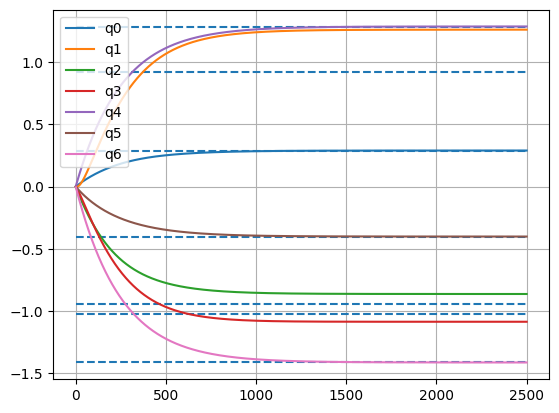

In [5]:
import matplotlib.pyplot as plt

history_q = np.array(history_q)

plt.hlines(target_q, 0, len(history_q), linestyles="dashed")
plt.plot(history_q, label=["q" + str(i) for i in range(7)])
plt.grid()
plt.legend()
plt.show()

# Example of setting the actuator types to "velocity" control and move with desired velocity

In [6]:
# update actuators
vel_motor = ActuatorVelocity(kv=200)

for actuator_id in range(model.nu):
    update_actuator(model, actuator_id, vel_motor)

# setup simulation
target_v = np.random.randn(7) * 0.5

duration = 3  # (seconds)
framerate = 30  # (Hz)
n_steps = int(np.ceil(duration * framerate)) + 1

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.

history_dq = []

while data.time < duration:
    data.ctrl[:] = target_v

    mujoco.mj_step(model, data)

    history_dq.append(data.qvel.copy())

    if len(frames) < data.time * framerate:
        renderer.update_scene(data, scene_option=dict())
        pixels = renderer.render()
        frames.append(pixels)

history_dq = np.array(history_dq)
mediapy.show_video(frames, fps=framerate)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


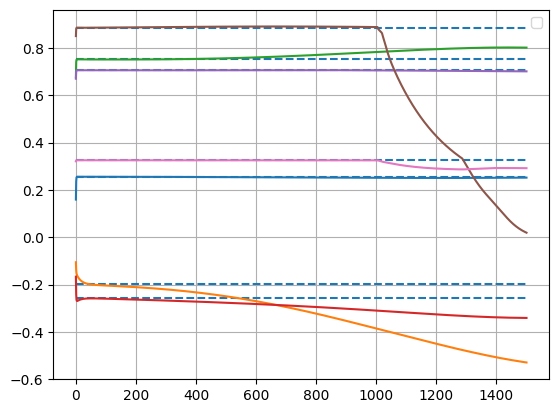

In [7]:
import matplotlib.pyplot as plt

plt.hlines(target_v, 0, len(history_dq), linestyles="dashed")
plt.plot(history_dq)
plt.grid()
plt.legend()
plt.show()

# Implement torque-based control for P2P motion

In [8]:
# set up actuators
torque_motor = ActuatorMotor()
for actuator_id in range(model.nu):
    update_actuator(model, actuator_id, torque_motor)

# update actuators
torque_motor = ActuatorPosition(kp=200, kd=100)

for actuator_id in range(model.nu):
    update_actuator(model, actuator_id, torque_motor)

# setup simulation
target_q = np.array(
    [
        0.28932849,
        0.92062463,
        -0.9442432,
        -1.02045466,
        1.2824041,
        -0.40766866,
        -1.41391154,
    ]
)

duration = 5  # (seconds)
framerate = 30  # (Hz)
n_steps = int(np.ceil(duration * framerate)) + 1

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.

history_q = []

kp, kd = 200, 100

while data.time < duration:
    # use PD controller with inverse dynamics

    # compute desired acceleration
    target_acc = kp * (target_q - data.qpos) - kd * data.qvel
    prev = data.qacc.copy()

    # inverse dynamics to compute required torque
    data.qacc[:] = target_acc
    mujoco.mj_inverse(model, data)
    sol = data.qfrc_inverse.copy()

    data.qacc[:] = prev

    # set torque as control
    data.ctrl[:] = sol

    mujoco.mj_step(model, data)

    history_q.append(data.qpos.copy())

    if len(frames) < data.time * framerate:
        renderer.update_scene(data, scene_option=dict())
        pixels = renderer.render()
        frames.append(pixels)

mediapy.show_video(frames, fps=framerate)